<a href="https://colab.research.google.com/github/yuanxy33/Authorship-Attribution/blob/master/Image%20Caption%20Generation%20(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text preparation 

We need to build a vocabulary.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Mounted Drive if using Colab; otherwise, your local path
root = "/content/drive/My Drive/AI_CW2_DATASET/" # <--- replace this with your root data directory
caption_dir = root + "Flickr8k_text/"                       # <--- replace these too
image_dir = root + "Flickr8k_Dataset/Flicker8k_Dataset/"                           # <---


token_file = "Flickr8k.token.txt"

print((caption_dir + token_file))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/AI_CW2_DATASET/Flickr8k_text/Flickr8k.token.txt


A helper function to read in our ground truth text file.

In [ ]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines


You can read all the ground truth captions (5 per image), into memory as follows:

In [ ]:
lines = read_lines(caption_dir + token_file)

In [ ]:
lines[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [ ]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


In [ ]:
import re
word = []
all_word = []
image_ids = []


for i in lines:
  d  = i.split('\t')
  z= d[0].split('#', 1)
  a = z[0].split('.jpg')
  image_ids.append(a[0])
  all_word.append(d[1])


for x in all_word:
  g = x.split()
  for a in g:
    if re.search('[a-zA-Z]', a): 
      d = a.lower()
      word.append(d)



Build the vocabulary.

In [ ]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')


Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

Don't add words that appear three times or less.

In [ ]:
set_word = set(word)
list_word_more_than_4 = []

for i in set_word:
  if word.count(i) > 3:
    list_word_more_than_4.append(i)


In [ ]:
len(list_word_more_than_4)

3421

In [ ]:
len(vocab)

4

In [ ]:
for i in list_word_more_than_4:
  vocab.add_word(i)

 #adding words with frequency more than 3 into the vocab

## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

In [ ]:
cleaned_captions =  []


for x in all_word:
  caption_string = ""
  g = x.split()
  for a in g:
    if re.search('[a-zA-Z]', a): 
      d = a.lower()
      caption_string = caption_string +  " " + str(d)
 
  caption_string = caption_string.strip()

  cleaned_captions.append(caption_string)



In [ ]:
cleaned_captions[:5]


['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

The dataframe for the image paths and captions.

In [ ]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [ ]:
data_df.head(n=5)



,image_id,path,caption
0,1000268201_693b08cb0e,/content/drive/My Drive/AI_CW2_DATASET/Flickr8...,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,/content/drive/My Drive/AI_CW2_DATASET/Flickr8...,a girl going into a wooden building
2,1000268201_693b08cb0e,/content/drive/My Drive/AI_CW2_DATASET/Flickr8...,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e,/content/drive/My Drive/AI_CW2_DATASET/Flickr8...,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,/content/drive/My Drive/AI_CW2_DATASET/Flickr8...,a little girl in a pink dress going into a woo...


This is the Flickr8k class for the dataset.

In [ ]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [ ]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)  

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [ ]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?  #because resnet uses 224 as input
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [ ]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)


Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [ ]:
import torch

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    collate_fn=caption_collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    collate_fn=caption_collate_fn
)

## Encoder and decoder models

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential 
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""

        #new
        
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)  #resize
        features = self.bn(self.linear(features))   
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        
        return features


class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderLSTM, self).__init__()
        
        # What is an embedding layer?  Converting vocab to vector representation
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)   #new

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed) 
    
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)  
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Set training parameters.

In [ ]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1   

Initialize the models and set the learning parameters.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


In [ ]:
# Model Training

#save initial model
model_path_encoder = root + 'LSTM_Save_Point/'+ 'encoder-{}.ckpt'.format(0)
model_path_decoder = root + 'LSTM_Save_Point/'+ 'decoder-{}.ckpt'.format(0)
torch.save(decoder.state_dict(), model_path_decoder)
torch.save(encoder.state_dict(), model_path_encoder)

total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, captions, lengths) in enumerate(train_loader):
      # Set mini-batch dataset
      images = images.to(device)
      captions = captions.to(device)
      # Packed as well as we'll compare to the decoder outputs
      targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

      # Extract features from image and pass to decoder
      features = encoder(images)
      outputs = decoder(features, captions, lengths)

      loss = criterion(outputs, targets) 
      # Zero gradients for both networks
      decoder.zero_grad()
      encoder.zero_grad()

      loss.backward()
      optimizer.step()

      # Print log info
      if i % log_step == 0:
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch, num_epochs, i, total_step, loss.item()))

  model_path_encoder = root + 'LSTM_Save_Point/'+ 'encoder-{}.ckpt'.format(epoch+1)
  model_path_decoder = root + 'LSTM_Save_Point/'+ 'decoder-{}.ckpt'.format(epoch+1)

  torch.save(decoder.state_dict(), model_path_decoder)
  torch.save(encoder.state_dict(), model_path_encoder)

#save model for every epochs

Epoch [0/5], Step [0/301], Loss: 8.1258
Epoch [0/5], Step [10/301], Loss: 5.5212
Epoch [0/5], Step [20/301], Loss: 4.9905
Epoch [0/5], Step [30/301], Loss: 4.6553
Epoch [0/5], Step [40/301], Loss: 4.3361
Epoch [0/5], Step [50/301], Loss: 4.2047
Epoch [0/5], Step [60/301], Loss: 4.0686
Epoch [0/5], Step [70/301], Loss: 3.8448
Epoch [0/5], Step [80/301], Loss: 3.9438
Epoch [0/5], Step [90/301], Loss: 3.7775
Epoch [0/5], Step [100/301], Loss: 3.6217
Epoch [0/5], Step [110/301], Loss: 3.6166
Epoch [0/5], Step [120/301], Loss: 3.6418
Epoch [0/5], Step [130/301], Loss: 3.4522
Epoch [0/5], Step [140/301], Loss: 3.4923
Epoch [0/5], Step [150/301], Loss: 3.5502
Epoch [0/5], Step [160/301], Loss: 3.3220
Epoch [0/5], Step [170/301], Loss: 3.4105
Epoch [0/5], Step [180/301], Loss: 3.2616
Epoch [0/5], Step [190/301], Loss: 3.3375
Epoch [0/5], Step [200/301], Loss: 3.1829
Epoch [0/5], Step [210/301], Loss: 3.1752
Epoch [0/5], Step [220/301], Loss: 3.1832
Epoch [0/5], Step [230/301], Loss: 3.2377
Epo

In [ ]:
#Setting the image Path the test set

test_image_path = [ data_df.iloc[train_size + 20].path , 
                   data_df.iloc[train_size + 30].path]

test_image_path

['/content/drive/My Drive/AI_CW2_DATASET/Flickr8k_Dataset/Flicker8k_Dataset/537758332_8beb9cf522.jpg',
 '/content/drive/My Drive/AI_CW2_DATASET/Flickr8k_Dataset/Flicker8k_Dataset/539493423_9d7d1b77fa.jpg']

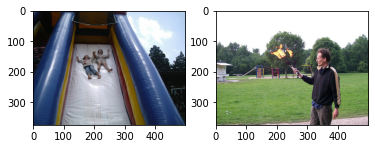

In [ ]:
#Plot the image, do not resize so that we see the details
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
image = Image.open(test_image_path[0])
plt.imshow(np.asarray(image ))

plt.subplot(1, 2, 2)
image = Image.open(test_image_path[1])
plt.imshow(np.asarray(image ))


In [ ]:
#SAMPLING
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
sf = SmoothingFunction()


def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

references = []
ref_image = [] #store every reference of the image


for x in range (6):     # for 0-5 epochs, 0 = before training
  Test_cout = 0
  encoder = EncoderCNN(embed_size).eval()
  decoder = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers)
  encoder = encoder.to(device)
  decoder = decoder.to(device)
  #load the encoder decoder
  model_path_encoder = root + 'LSTM_Save_Point/'+ 'encoder-{}.ckpt'.format(x)
  model_path_decoder = root + 'LSTM_Save_Point/'+ 'decoder-{}.ckpt'.format(x)
  encoder.load_state_dict(torch.load(model_path_encoder))
  decoder.load_state_dict(torch.load(model_path_decoder))

  
  print("Epoch  " + str(x))

  for i in test_image_path:  
    print("\tImage " + str(Test_cout+1) + "")
    # Prepare an image

    image = load_image(i, data_transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # remove <start> <end>
    sampled_ids=[ w for w in sampled_ids if w not in {vocab.__call__('<start>'), vocab.__call__('<end>')}]

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
  
    sentence = ' '.join(sampled_caption)
    print("\t\tGenerated Caption:  " + sentence)
    

    index_caption = data_df.index[ data_df['path'] == i] #Find first index of the caption 

    #Tokenize the caption and store into the string
    #Print BLEU score
    for j in range (5):

      cap = (data_df.iloc[index_caption[0] + j].caption).split()

      references.append(cap)
    ref_image.append(references) 
    candidate = sentence.split()
    BLEU_Score = sentence_bleu(references,candidate, smoothing_function=sf.method7)
    print("\t\tBLEU score:"  + str("{:.2f}".format(BLEU_Score)))   
    Test_cout = Test_cout+1
    references = []
  print("\n")

print("####### Reference #############")
for i in range (2):
  print("Image {} reference is".format(str(i+1)))
  for j in range(5):
    print(ref_image[i][j])
  print("\n")

Epoch  0
	Image 1
		Generated Caption:  knit clothed have cast milkshake formations being blowing blowing red-haired jumping ground greenery patterned angels wig squirt lanterns lanterns surfer
		BLEU score:0.00
	Image 2
		Generated Caption:  challenging legs stomach owners person rabbit up fist much chickens lanterns lanterns surfer teddy mirror eating misses observing wig visible
		BLEU score:0.00


Epoch  1
	Image 1
		Generated Caption:  a boy in a blue shirt is standing on a ramp
		BLEU score:0.26
	Image 2
		Generated Caption:  a man in a blue shirt and a red shirt and a red shirt and a red shirt and
		BLEU score:0.28


Epoch  2
	Image 1
		Generated Caption:  a boy in a blue shirt is jumping off a ramp
		BLEU score:0.29
	Image 2
		Generated Caption:  a man and a woman are standing in front of a large building
		BLEU score:0.31


Epoch  3
	Image 1
		Generated Caption:  a boy in a blue shirt is jumping off a ramp
		BLEU score:0.29
	Image 2
		Generated Caption:  a man and a woman are 

In [ ]:
#Setting the image Path test set

test_image_path = [ data_df.iloc[train_size + 40].path, 
                   data_df.iloc[train_size + 50].path,
                   data_df.iloc[train_size + 60].path,
                   data_df.iloc[train_size + 70].path,
                   data_df.iloc[train_size + 80].path ,
                   data_df.iloc[train_size + 90].path 
                   ]



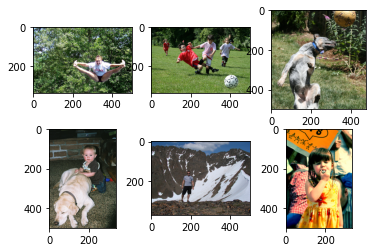

In [ ]:
#Plot the image
import matplotlib.pyplot as plt

plt.subplot(2, 3, 1)
image = Image.open(test_image_path[0])
plt.imshow(np.asarray(image ))

plt.subplot(2, 3, 2)
image = Image.open(test_image_path[1])
plt.imshow(np.asarray(image ))

plt.subplot(2, 3, 3)
image = Image.open(test_image_path[2])
plt.imshow(np.asarray(image ))

plt.subplot(2, 3, 4)
image = Image.open(test_image_path[3])
plt.imshow(np.asarray(image ))

plt.subplot(2, 3, 5)
image = Image.open(test_image_path[4])
plt.imshow(np.asarray(image ))

plt.subplot(2, 3, 6)
image = Image.open(test_image_path[5])
plt.imshow(np.asarray(image ))


In [ ]:
#SAMPLING from fully train model
references = []
ref_image = [] #store every reference of the image

#Load the fully train model and evaluate BLEU
for x in range (5,6):     # for 0-5 epochs, 0 = before training
  Test_cout = 0
  encoder = EncoderCNN(embed_size).eval()
  decoder = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers)
  encoder = encoder.to(device)
  decoder = decoder.to(device)

  model_path_encoder = root + 'LSTM_Save_Point/'+ 'encoder-{}.ckpt'.format(x)
  model_path_decoder = root + 'LSTM_Save_Point/'+ 'decoder-{}.ckpt'.format(x)
  encoder.load_state_dict(torch.load(model_path_encoder))
  decoder.load_state_dict(torch.load(model_path_decoder))
  
  print("Epoch  " + str(x))

  for i in test_image_path:  
    print("\tImage " + str(Test_cout+1) + "")
    # Prepare an image

    image = load_image(i, data_transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # eliminate <start> <end>
    sampled_ids=[ w for w in sampled_ids if w not in {vocab.__call__('<start>'), vocab.__call__('<end>')}]

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
  
    sentence = ' '.join(sampled_caption)
    print("\t\tGenerated Caption:  " + sentence)
    
    #print( i )
    index_caption = data_df.index[ data_df['path'] == i] #Find first index of the caption 
    #print(index_caption)
 
    for j in range (5):
      cap = (data_df.iloc[index_caption[0] + j].caption).split()
      #print(cap)
      references.append(cap)
    ref_image.append(references) 
    candidate = sentence.split()
    BLEU_Score = sentence_bleu(references,candidate, smoothing_function=sf.method7)
    print("\t\tBLEU score:"  + str("{:.2f}".format(BLEU_Score)))   
    Test_cout = Test_cout+1
    references = []
  print("\n")

print("####### Reference #############")
for i in range (6):
  print("Image {} reference is".format(str(i+1)))
  for j in range(5):
    print(ref_image[i][j])
  print("\n")

Epoch  5
	Image 1
		Generated Caption:  a girl in a white shirt and blue shorts is jumping into the air
		BLEU score:0.34
	Image 2
		Generated Caption:  a group of people are playing soccer
		BLEU score:0.33
	Image 3
		Generated Caption:  a black and white dog is running on the grass
		BLEU score:0.33
	Image 4
		Generated Caption:  a small white dog is playing with a tennis ball on the beach
		BLEU score:0.32
	Image 5
		Generated Caption:  a man is standing on a snowy mountain
		BLEU score:0.44
	Image 6
		Generated Caption:  a woman in a red dress is holding a baby in a red dress
		BLEU score:0.32


####### Reference #############
Image 1 reference is
['a', 'girl', 'doing', 'the', 'splits', 'in', 'midair']
['a', 'girl', 'is', 'doing', 'the', 'splits', 'in', 'the', 'air', 'in', 'front', 'of', 'some', 'trees']
['a', 'woman', 'grabbing', 'her', 'feet', 'while', 'jumping', 'in', 'front', 'of', 'trees']
['a', 'young', 'girl', 'doing', 'a', 'trick', 'in', 'midair', 'in', 'front', 'of', 'a', 

In [ ]:
test_path = []
for i in range(train_size, 40455, 5 ):
  test_path.append(data_df.iloc[i].path)


In [ ]:
from nltk.translate.bleu_score import SmoothingFunction
sf = SmoothingFunction()

#SAMPLING from fully train model
references = []
BLEU_list = []
ref_smooth = []
gen_cap = []

#Load the fully train model and evaluate BLEU
for x in range (5,6):     # for 0-5 epochs, 0 = before training
  encoder = EncoderCNN(embed_size).eval()
  decoder = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers)
  encoder = encoder.to(device)
  decoder = decoder.to(device)

  model_path_encoder = root + 'LSTM_Save_Point/'+ 'encoder-{}.ckpt'.format(x)
  model_path_decoder = root + 'LSTM_Save_Point/'+ 'decoder-{}.ckpt'.format(x)
  encoder.load_state_dict(torch.load(model_path_encoder))
  decoder.load_state_dict(torch.load(model_path_decoder))
  
  print("Epoch  " + str(x))

  for i in test_path:  
    image = load_image(i, data_transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # eliminate <start> <end>
    sampled_ids=[ w for w in sampled_ids if w not in {vocab.__call__('<start>'), vocab.__call__('<end>')}]

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break

    sentence = ' '.join(sampled_caption)
    print("\t\tGenerated Caption:  " + sentence)
    
    gen_cap.append(sentence)
    index_caption = data_df.index[ data_df['path'] == i] #Find first index of the caption

    for j in range (5):
      cap = (data_df.iloc[index_caption[0] + j].caption).split()
      print(cap)
      references.append(cap)
    ref_smooth.append(references)
    candidate = sentence.split()
    BLEU_Score = sentence_bleu(references,candidate, smoothing_function=sf.method7)
    BLEU_list.append(BLEU_Score)
    references = []

Epoch  5
		Generated Caption:  a young boy jumps off of a slide into a pool
['a', 'child', 'playing', 'on', 'the', 'monkey', 'bars', 'at', 'a', 'playground', 'with', 'an', 'adult', 'present']
['a', 'girl', 'hangs', 'on', 'the', 'bars']
['a', 'kid', 'hangs', 'upside', 'down', 'on', 'the', 'monkey', 'bars', 'at', 'a', 'playground']
['a', 'young', 'children', 'hanging', 'upside', 'at', 'the', 'playground']
['girl', 'hanging', 'upside', 'down', 'on', 'blue', 'monkey', 'bars']
		Generated Caption:  a dog jumps over a hurdle in a field
['a', 'brown', 'and', 'white', 'sheltie', 'leaping', 'over', 'a', 'rail']
['a', 'collie', 'is', 'running', 'through', 'an', 'obstacle', 'course']
['collie', 'jumping', 'over', 'a', 'training', 'hurdle', 'that', 'is', 'on', 'the', 'grass']
['collie', 'making', 'a', 'jump', 'over', 'a', 'yellow', 'hurdle']
['the', 'dog', 'is', 'leaping', 'over', 'a', 'hurdle']
		Generated Caption:  a little girl in a pink hat is running through the grass
['a', 'little', 'girl', 

In [ ]:
len(BLEU_list)

405

In [ ]:
len(ref_smooth)

405

In [ ]:
data = {'Gen_caption':gen_cap, 'Reference':ref_smooth, 'BLEU': BLEU_list} 
data_final_df = pd.DataFrame(data)

In [ ]:
data_final_df.to_csv("/content/drive/My Drive/AI_CW2_DATASET/LSTM_Save_Point/Data_final.csv")